

In the production of electrical drives, a high product quality is needed. As the industry of electric drive production is confronted by trends such as electric mobility and continuing industrial automation, efficient and flexible processes are needed more than ever. With current quality monitoring technology, accurate quality checking is not feasible.

Electrical motors mainly consist of the rotor, the stator and the surrounding housing. The production process can be separated into multiple sub-processes, which can be seen below. The exact sequence of these steps however depends on the motor type. First, the individual components are manufactured and assembled into subassemblies such as the rotor and the stator. Finally, all components (the housing, the stator, the rotor as well as bearings and end shields) are assembled and the motor is checked in an end-of-line (EOL) test.

This final assembly is of great importance, as all parts need to be assembled in the correct way, to ensure smooth operation. Therefore, a quality monitoring system is needed, raising alarm if assembly errors are detected. However, especially in lot-size one production, traditional computer vision systems might reach their limits and cannot be used anymore.

Thus, in this lab we will build a smart quality monitoring system for the electric drives production. An already existing visual sensor captures images of the electric motor after assembly. These images show the part from the top, as well from the side perspective. It is now the target to decide whether the motor is fully assembled, or whether one of multiple defects is present. There is data from three different defects available: *missing cover*, *missing screw* and *not screwed*. Examples of these defects can be seen below. To achieve this, we will investigate two different machine learning models: *Support Vector Machines* (SVM) and *Convolutional Neural Networks* (CNN).

Further background information can be found in this paper: [Mayr et al., Machine Learning in Electric Motor Production - Potentials, Challenges and Exemplary Applications](https://ieeexplore.ieee.org/document/9011861)

![Introduction](./img/Intro_dataset.png)

In [1]:
# Mount your GDrive - Authentication required - Please follow the instructions
from google.colab import drive
from google.colab.patches import cv2_imshow
import sys, os
drive.mount('/content/gdrive')

# Change the current working directory

# Depending on your directory, you may want to adjust this
dir_path = '/content/gdrive/My Drive/Machine Learning/Image Classification/ML4Eng_I_Exercise_Image_Classification/ML4Eng_I_Exercise_Image_Classification'
sys.path.append(dir_path)
os.chdir(dir_path)

Mounted at /content/gdrive


FileNotFoundError: ignored

In [ ]:
# As in the previous exercises, we'll import commonly used libraries right at the start
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow as tf
# The check.py script contains the quality gates you can use for selftesting throughout the lab
from scripts.check import *

In [ ]:
# Loading one image in top view
path = "./data/top/L1_C_3.JPG"
img = cv2.imread(path)
img.shape

(1024, 1024, 3)

In [ ]:
type(img)

numpy.ndarray

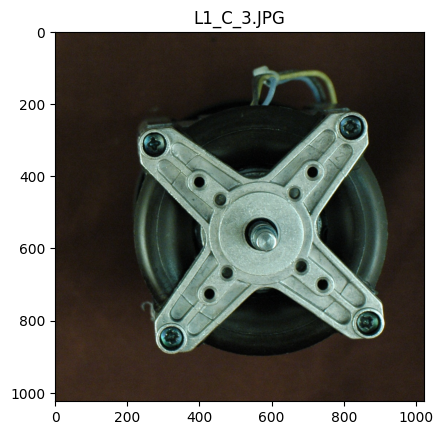

In [ ]:
plt.title(path.split('/')[-1]) # Set the filename as image title
plt.imshow(img) # Display the image
plt.show()

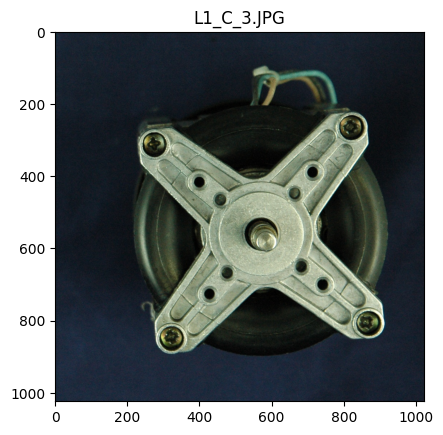

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert image from bgr to rgb
plt.title(path.split('/')[-1]) # Set the filename as image title
plt.imshow(img) # Display the image
plt.show()

In [ ]:
import glob

def get_label_from_name(path):
    if "_C_" in path:
        return "Complete"
    if "_MC_" in path:
        return "Missing cover"
    if "_MS_" in path:
        return "Missing screw"
    if "_NS_" in path:
        return "Not screwed"
    return "n/a" # TODO: Raise error

def load_features_labels(folder, size = (64,32), flatten = True, color = False, identifiers=['NS', 'MS', 'MC', 'C']):
    features, labels = [], [] # Empty lists for storing the features and labels
    # Iterate over all imagefiles in the given folder
    for file in glob.glob(folder + "/*.JPG"):
        if any(identifier in file for identifier in identifiers):
            #############################
            img = cv2.imread(file)
            features.append(img)
            lab = get_label_from_name(file)
            labels.append(lab)
            #############################


    return features, labels # Return results

In [ ]:
features, labels = load_features_labels("./data/top")
print("Number of features:", len(features))
print("Number of labels:", len(labels))

# Check data import
quality_gate_111(features, labels)

Number of features: 117
Number of labels: 117


'Quality gate passed :)'

In [ ]:
def image_preprocessing(img, size = (64,32), flatten = True, color = False):
    img = cv2.resize(img, size)
    if not color:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if flatten:
        img = img.reshape(-1)
    return img

In [ ]:
def load_features_labels(folder, size = (64,32), flatten = True, color = False, identifiers=['NS', 'MS', 'MC', 'C']):
    features, labels = [], [] # Empty lists for storing the features and labels
    # Iterate over all imagefiles in the given folder
    for file in glob.glob(folder + "/*.JPG"):
        if any(identifier in file for identifier in identifiers):
            #############################
            img = cv2.imread(file)
            preimg = image_preprocessing(img, size, flatten, color)
            features.append(preimg)
            lab = get_label_from_name(file)
            labels.append(lab)
            #############################

    return features, labels # Return results

In [ ]:
################
# Quality gate #
################
features, labels = load_features_labels("./data/top", size=(8, 8), flatten=True, color=False)
quality_gate_112(features, labels)


'Quality gate passed :)'

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=(0.1, 0.3))

features, labels = load_features_labels("./data/top", size=(1024, 1024), flatten=False, color=True)
classes = ['Complete', 'Missing cover', 'Missing screw', 'Not screwed']
for i, ax in enumerate(grid):
    selectedClass = classes[i%4] # Select class
    images = np.array(features)[np.array(labels)==selectedClass] # Preselect images based on class
    image = images[i//4] # Select image
    ax.imshow(image) # Plot image
    ax.set_title(selectedClass) # Assign class as image title
plt.show()

In [ ]:
from collections import Counter
print(Counter(labels))

Counter({'Not screwed': 47, 'Missing screw': 42, 'Missing cover': 22, 'Complete': 6})


Text(0, 0.5, 'Total quantity')

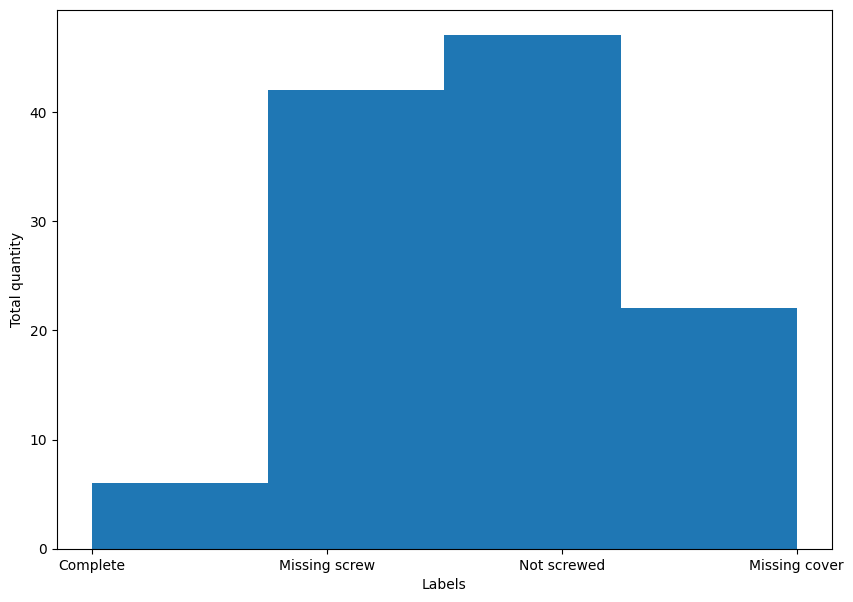

In [ ]:
#############################
%matplotlib inline
plt.figure(figsize=(10,7))
plt.hist(labels, bins = 4)
plt.xlabel('Labels')
plt.ylabel('Total quantity')
#############################



In [ ]:
features, labels = load_features_labels("./data/top", size=(16,16), color=True, flatten=True, identifiers=['MC', 'MS', 'C'])
features = np.asarray(features)
labels = np.asarray(labels)
print("Shape feature vector:", features.shape)
print("Shape label vector:", labels.shape)

Shape feature vector: (70, 768)
Shape label vector: (70,)


In [ ]:
from sklearn.model_selection import train_test_split
######################################
# Please complete the following line #
######################################

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, train_size=0.7, random_state=42, stratify=labels)


################
# Quality gate #
################

quality_gate_13(X_train, X_test)

'Quality gate passed :)'

In [ ]:
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
clf = SVC(kernel="rbf", gamma=0.01, C=0.0003) # Initialize the SVM
clf.fit(X_train, y_train, sample_weight=compute_sample_weight('balanced', y_train)) # Train the SVM
print("Score:", clf.score(X_test, y_test)) # Test the model

Score: 0.6190476190476191


               precision    recall  f1-score   support

     Complete       0.00      0.00      0.00         2
Missing cover       0.00      0.00      0.00         6
Missing screw       0.62      1.00      0.76        13

     accuracy                           0.62        21
    macro avg       0.21      0.33      0.25        21
 weighted avg       0.38      0.62      0.47        21



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


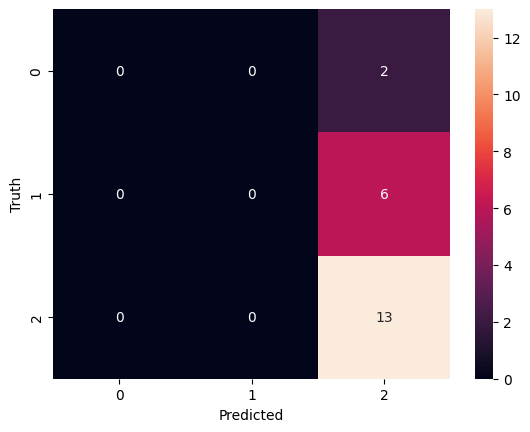

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, clf.predict(X_test))
ax=sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test, clf.predict(X_test)))

In [ ]:
features, labels = load_features_labels("./data/top", size=(128,128), color=True, flatten=True, identifiers=['MC', 'MS', 'C'])
features = np.asarray(features)
labels = np.asarray(labels)
print("Shape feature vector:", features.shape)
print("Shape label vector:", labels.shape)

Shape feature vector: (70, 49152)
Shape label vector: (70,)


In [ ]:
######################################
# Please complete the following line #
######################################
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, train_size=0.7, random_state=42, stratify=labels)


In [ ]:
# The sklearn preprocessing library contains a variety of useful data preprocessing tools such as one hot encoding
from sklearn.preprocessing import OneHotEncoder
# Display the first label before encoding
print("Label of first sample before OneHot encoding:", y_train[0])
# Create the encoder object
enc = OneHotEncoder(sparse=False) # Generate Encoder
# With the fit_transform function, the encoder is fitted to the existing labels and transforms the dataset into its binary representation
y_train = enc.fit_transform(y_train.reshape(-1, 1))
# Display the first label after encoding
print("Label of first sample after OneHot encoding:", y_train[0])
# Data preprocessing should always be fitted on the training dataset, but applied to both, the training and the testing dataset. Thus the fit_transform function is only applied to the training dataset, while the the test dataset is transformed using the transform function and the fitted preprocessing module
y_test = enc.transform(y_test.reshape(-1, 1))

Label of first sample before OneHot encoding: Missing cover
Label of first sample after OneHot encoding: [0. 1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout

model = Sequential()
model.add(Dense(32, input_shape = X_train[0].shape))
model.add(Activation("relu"))
model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dense(y_train[0].shape[0]))
model.add(Activation("softmax"))

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                1572896   
                                                                 
 activation_6 (Activation)   (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 activation_7 (Activation)   (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 3)                 51        
                                                                 
 activation_8 (Activation)   (None, 3)                 0         
                                                                 
Total params: 1,573,475
Trainable params: 1,573,475
No

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

Now, the model can be trained using the datasets defined before.

In [ ]:
model.fit(X_train, y_train, epochs = 20, batch_size = 8, validation_split=0.2, verbose = 1)

Epoch 1/20
5/5 [==============================] - 1s 79ms/step - loss: 496.2339 - accuracy: 0.2564 - val_loss: 130.1470 - val_accuracy: 0.4000
Epoch 2/20
5/5 [==============================] - 0s 27ms/step - loss: 278.4264 - accuracy: 0.5385 - val_loss: 39.4355 - val_accuracy: 0.7000
Epoch 3/20
5/5 [==============================] - 0s 27ms/step - loss: 360.4145 - accuracy: 0.5897 - val_loss: 17.2823 - val_accuracy: 0.9000
Epoch 4/20
5/5 [==============================] - 0s 26ms/step - loss: 239.0031 - accuracy: 0.5897 - val_loss: 370.0382 - val_accuracy: 0.5000
Epoch 5/20
5/5 [==============================] - 0s 32ms/step - loss: 211.8629 - accuracy: 0.5641 - val_loss: 13.3252 - val_accuracy: 0.8000
Epoch 6/20
5/5 [==============================] - 0s 27ms/step - loss: 91.1012 - accuracy: 0.6923 - val_loss: 385.4578 - val_accuracy: 0.6000
Epoch 7/20
5/5 [==============================] - 0s 30ms/step - loss: 149.0156 - accuracy: 0.6923 - val_loss: 165.2939 - val_accuracy: 0.6000
Epo

You can use the following function to evaluate your model.

In [ ]:
def evaluate_model(X_test, y_test, model):
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, classification_report

    y_pred = model.predict(X_test)
    res = np.zeros_like(y_pred)
    for i in range(len(np.argmax(y_pred, axis=1))):
        res[i, np.argmax(y_pred,axis=1)[i]]=1
    y_pred = res
    cm = confusion_matrix(enc.inverse_transform(y_test), enc.inverse_transform(y_pred))
    ax=sns.heatmap(cm, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    print(classification_report(enc.inverse_transform(y_test), enc.inverse_transform(y_pred), zero_division=0))

1/1 [==============================] - 0s 72ms/step
               precision    recall  f1-score   support

     Complete       1.00      0.50      0.67         2
Missing cover       0.60      0.50      0.55         6
Missing screw       0.73      0.85      0.79        13

     accuracy                           0.71        21
    macro avg       0.78      0.62      0.67        21
 weighted avg       0.72      0.71      0.71        21



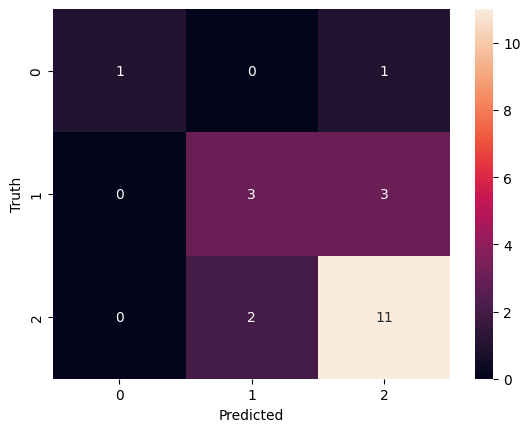

In [ ]:
evaluate_model(X_test, y_test, model)

In [ ]:
features, labels = load_features_labels("./data/top", size=(512,512), color=True, flatten=False, identifiers=['MC', 'MS', 'C'])
features = np.array(features) # Datatype conversion of feature vector from list to array
labels = np.array(labels) # Datatype conversion of label vector from list to array
print("Shape feature vector:", features.shape)
print("Shape label vector:", labels.shape)

Shape feature vector: (70, 512, 512, 3)
Shape label vector: (70,)


In [ ]:
#######################################
# Please complete the following lines #
#######################################

def split_data(features, labels):
    return train_test_split(features, labels, test_size=0.3, train_size=0.7, random_state = 42, stratify=labels)

def encode_data(y_train, y_test):
    from sklearn.preprocessing import OneHotEncoder
    enc = OneHotEncoder(sparse=False)
    y_train = enc.fit_transform(y_train.reshape(-1, 1))
    y_test = enc.transform(y_test.reshape(-1, 1))
    return y_train, y_test


################
# Quality gate #
################

X_train, X_test, y_train, y_test = split_data(features, labels)
y_train, y_test = encode_labels(y_train, y_test)
print("Label of first sample after OneHot encoding:", y_train[0])
quality_gate_141(y_train, y_test)

Label of first sample after OneHot encoding: [0. 1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


'Quality gate passed :)'

In [ ]:
#Troubleshooting
print("Shape X_train = ", X_train[0].shape)
print("Shape y_train = ", y_train.shape)
print("Shape y_test = ", y_test.shape),
print("ndim X_train = ", X_train[0].ndim)

Shape X_train =  (512, 512, 3)
Shape y_train =  (49, 3)
Shape y_test =  (21, 3)
ndim X_train =  3


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, GlobalMaxPooling2D

model = Sequential()
model.add(Conv2D(8, 5,  input_shape = X_train[0].shape, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(16, 3, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, activation = 'relu', padding="same"))
model.add(GlobalMaxPooling2D())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(y_train[0].shape[0], activation = 'softmax'))

print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 512, 512, 8)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 8)      0         
 )                                                               
                                                                 
 conv2d_8 (Conv2D)           (None, 256, 256, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 global_max_pooling2d (Globa  (None, 32)             

In [ ]:
from tensorflow.keras.optimizers import Adam
optimizer=Adam(learning_rate=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [ ]:
model.fit(np.array(X_train), np.array(y_train), epochs = 75, batch_size = 32, validation_split=0.1,
          verbose = 1, sample_weight=compute_sample_weight('balanced', y_train))

Epoch 1/75
2/2 [==============================] - ETA: 0s - loss: 24.9827 - accuracy: 0.2273

2/2 [==============================] - 15s 5s/step - loss: 24.9827 - accuracy: 0.2273 - val_loss: 18.1785 - val_accuracy: 0.0000e+00
Epoch 2/75
2/2 [==============================] - ETA: 0s - loss: 13.5404 - accuracy: 0.0909

2/2 [==============================] - 12s 5s/step - loss: 13.5404 - accuracy: 0.0909 - val_loss: 2.9988 - val_accuracy: 0.0000e+00
Epoch 3/75
2/2 [==============================] - ETA: 0s - loss: 4.8336 - accuracy: 0.2045

2/2 [==============================] - 10s 3s/step - loss: 4.8336 - accuracy: 0.2045 - val_loss: 1.6104 - val_accuracy: 0.8000
Epoch 4/75
2/2 [==============================] - ETA: 0s - loss: 4.8006 - accuracy: 0.5909

2/2 [==============================] - 12s 3s/step - loss: 4.8006 - accuracy: 0.5909 - val_loss: 1.0300 - val_accuracy: 0.4000
Epoch 5/75
2/2 [==============================] - ETA: 0s - loss: 1.4701 - accuracy: 0.4545

2/2 [==============================] - 12s 3s/step - loss: 1.4701 - accuracy: 0.4545 - val_loss: 2.0230 - val_accuracy: 0.2000
Epoch 6/75
2/2 [==============================] - ETA: 0s - loss: 2.0372 - accuracy: 0.2955

2/2 [==============================] - 12s 4s/step - loss: 2.0372 - accuracy: 0.2955 - val_loss: 2.3100 - val_accuracy: 0.2000
Epoch 7/75
2/2 [==============================] - ETA: 0s - loss: 2.4556 - accuracy: 0.2955

2/2 [==============================] - 14s 5s/step - loss: 2.4556 - accuracy: 0.2955 - val_loss: 1.4467 - val_accuracy: 0.2000
Epoch 8/75
2/2 [==============================] - ETA: 0s - loss: 1.8132 - accuracy: 0.3409

2/2 [==============================] - 11s 4s/step - loss: 1.8132 - accuracy: 0.3409 - val_loss: 0.5345 - val_accuracy: 0.6000
Epoch 9/75
2/2 [==============================] - ETA: 0s - loss: 1.5084 - accuracy: 0.4545

2/2 [==============================] - 11s 3s/step - loss: 1.5084 - accuracy: 0.4545 - val_loss: 0.8607 - val_accuracy: 0.6000
Epoch 10/75
2/2 [==============================] - ETA: 0s - loss: 0.8726 - accuracy: 0.5455

2/2 [==============================] - 12s 3s/step - loss: 0.8726 - accuracy: 0.5455 - val_loss: 0.8796 - val_accuracy: 0.4000
Epoch 11/75
2/2 [==============================] - ETA: 0s - loss: 0.9416 - accuracy: 0.4091

2/2 [==============================] - 12s 3s/step - loss: 0.9416 - accuracy: 0.4091 - val_loss: 0.8299 - val_accuracy: 0.6000
Epoch 12/75
2/2 [==============================] - ETA: 0s - loss: 1.0446 - accuracy: 0.4318

2/2 [==============================] - 12s 5s/step - loss: 1.0446 - accuracy: 0.4318 - val_loss: 0.6546 - val_accuracy: 0.6000
Epoch 13/75
2/2 [==============================] - ETA: 0s - loss: 0.8556 - accuracy: 0.4773

2/2 [==============================] - 11s 4s/step - loss: 0.8556 - accuracy: 0.4773 - val_loss: 0.3404 - val_accuracy: 0.6000
Epoch 14/75
2/2 [==============================] - ETA: 0s - loss: 0.5552 - accuracy: 0.7045

2/2 [==============================] - 11s 3s/step - loss: 0.5552 - accuracy: 0.7045 - val_loss: 0.2711 - val_accuracy: 0.6000
Epoch 15/75
2/2 [==============================] - ETA: 0s - loss: 0.7911 - accuracy: 0.7045 

2/2 [==============================] - 16s 5s/step - loss: 0.7911 - accuracy: 0.7045 - val_loss: 0.3939 - val_accuracy: 0.6000
Epoch 16/75
2/2 [==============================] - ETA: 0s - loss: 0.5135 - accuracy: 0.7273

2/2 [==============================] - 12s 3s/step - loss: 0.5135 - accuracy: 0.7273 - val_loss: 0.4166 - val_accuracy: 0.6000
Epoch 17/75
2/2 [==============================] - ETA: 0s - loss: 0.2672 - accuracy: 0.7500

2/2 [==============================] - 12s 3s/step - loss: 0.2672 - accuracy: 0.7500 - val_loss: 0.6797 - val_accuracy: 0.6000
Epoch 18/75
2/2 [==============================] - ETA: 0s - loss: 0.3562 - accuracy: 0.6591

2/2 [==============================] - 12s 4s/step - loss: 0.3562 - accuracy: 0.6591 - val_loss: 0.6551 - val_accuracy: 0.6000
Epoch 19/75
2/2 [==============================] - ETA: 0s - loss: 0.2361 - accuracy: 0.7727

2/2 [==============================] - 11s 4s/step - loss: 0.2361 - accuracy: 0.7727 - val_loss: 0.5721 - val_accuracy: 0.4000
Epoch 20/75
2/2 [==============================] - ETA: 0s - loss: 0.2577 - accuracy: 0.8182

2/2 [==============================] - 11s 3s/step - loss: 0.2577 - accuracy: 0.8182 - val_loss: 0.5824 - val_accuracy: 0.4000
Epoch 21/75
2/2 [==============================] - ETA: 0s - loss: 0.3056 - accuracy: 0.8864

2/2 [==============================] - 12s 3s/step - loss: 0.3056 - accuracy: 0.8864 - val_loss: 0.4770 - val_accuracy: 0.6000
Epoch 22/75
2/2 [==============================] - ETA: 0s - loss: 0.1567 - accuracy: 0.8864

2/2 [==============================] - 12s 3s/step - loss: 0.1567 - accuracy: 0.8864 - val_loss: 0.5571 - val_accuracy: 0.6000
Epoch 23/75
2/2 [==============================] - ETA: 0s - loss: 0.1742 - accuracy: 0.7955

2/2 [==============================] - 12s 5s/step - loss: 0.1742 - accuracy: 0.7955 - val_loss: 0.5349 - val_accuracy: 0.6000
Epoch 24/75
2/2 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 0.8636

2/2 [==============================] - 11s 4s/step - loss: 0.1256 - accuracy: 0.8636 - val_loss: 0.4165 - val_accuracy: 0.6000
Epoch 25/75
2/2 [==============================] - ETA: 0s - loss: 0.0672 - accuracy: 1.0000

2/2 [==============================] - 11s 3s/step - loss: 0.0672 - accuracy: 1.0000 - val_loss: 0.3902 - val_accuracy: 0.4000
Epoch 26/75
2/2 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 1.0000

2/2 [==============================] - 14s 5s/step - loss: 0.0729 - accuracy: 1.0000 - val_loss: 0.3480 - val_accuracy: 0.6000
Epoch 27/75
2/2 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 1.0000

2/2 [==============================] - 12s 3s/step - loss: 0.0541 - accuracy: 1.0000 - val_loss: 0.3217 - val_accuracy: 0.6000
Epoch 28/75
2/2 [==============================] - ETA: 0s - loss: 0.0395 - accuracy: 1.0000

2/2 [==============================] - 12s 4s/step - loss: 0.0395 - accuracy: 1.0000 - val_loss: 0.3498 - val_accuracy: 0.6000
Epoch 29/75
2/2 [==============================] - ETA: 0s - loss: 0.0403 - accuracy: 1.0000

2/2 [==============================] - 14s 5s/step - loss: 0.0403 - accuracy: 1.0000 - val_loss: 0.3715 - val_accuracy: 0.6000
Epoch 30/75
2/2 [==============================] - ETA: 0s - loss: 0.0400 - accuracy: 1.0000

2/2 [==============================] - 13s 5s/step - loss: 0.0400 - accuracy: 1.0000 - val_loss: 0.3409 - val_accuracy: 0.6000
Epoch 31/75
2/2 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 1.0000

2/2 [==============================] - 10s 3s/step - loss: 0.0326 - accuracy: 1.0000 - val_loss: 0.2915 - val_accuracy: 0.6000
Epoch 32/75
2/2 [==============================] - ETA: 0s - loss: 0.0294 - accuracy: 1.0000

2/2 [==============================] - 12s 3s/step - loss: 0.0294 - accuracy: 1.0000 - val_loss: 0.2565 - val_accuracy: 0.6000
Epoch 33/75
2/2 [==============================] - ETA: 0s - loss: 0.0266 - accuracy: 1.0000

2/2 [==============================] - 12s 3s/step - loss: 0.0266 - accuracy: 1.0000 - val_loss: 0.2547 - val_accuracy: 0.6000
Epoch 34/75
2/2 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 1.0000

2/2 [==============================] - 12s 4s/step - loss: 0.0249 - accuracy: 1.0000 - val_loss: 0.2683 - val_accuracy: 0.6000
Epoch 35/75
2/2 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 1.0000

2/2 [==============================] - 11s 4s/step - loss: 0.0224 - accuracy: 1.0000 - val_loss: 0.2869 - val_accuracy: 0.6000
Epoch 36/75
2/2 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 1.0000

2/2 [==============================] - 11s 3s/step - loss: 0.0209 - accuracy: 1.0000 - val_loss: 0.3040 - val_accuracy: 0.6000
Epoch 37/75
2/2 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 1.0000

2/2 [==============================] - 12s 3s/step - loss: 0.0209 - accuracy: 1.0000 - val_loss: 0.3124 - val_accuracy: 0.6000
Epoch 38/75
2/2 [==============================] - ETA: 0s - loss: 0.0203 - accuracy: 1.0000

2/2 [==============================] - 12s 3s/step - loss: 0.0203 - accuracy: 1.0000 - val_loss: 0.3030 - val_accuracy: 0.6000
Epoch 39/75
2/2 [==============================] - ETA: 0s - loss: 0.0191 - accuracy: 1.0000

2/2 [==============================] - 12s 5s/step - loss: 0.0191 - accuracy: 1.0000 - val_loss: 0.2817 - val_accuracy: 0.6000
Epoch 40/75
2/2 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 1.0000

2/2 [==============================] - 11s 4s/step - loss: 0.0178 - accuracy: 1.0000 - val_loss: 0.2554 - val_accuracy: 0.6000
Epoch 41/75
2/2 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 1.0000

2/2 [==============================] - 11s 3s/step - loss: 0.0163 - accuracy: 1.0000 - val_loss: 0.2316 - val_accuracy: 0.6000
Epoch 42/75
2/2 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 1.0000

2/2 [==============================] - 12s 3s/step - loss: 0.0156 - accuracy: 1.0000 - val_loss: 0.2095 - val_accuracy: 0.6000
Epoch 43/75
2/2 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 1.0000

2/2 [==============================] - 12s 3s/step - loss: 0.0155 - accuracy: 1.0000 - val_loss: 0.1955 - val_accuracy: 0.6000
Epoch 44/75
2/2 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 1.0000

2/2 [==============================] - 12s 5s/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 0.1912 - val_accuracy: 0.6000
Epoch 45/75
2/2 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 1.0000

2/2 [==============================] - 11s 5s/step - loss: 0.0146 - accuracy: 1.0000 - val_loss: 0.1925 - val_accuracy: 0.6000
Epoch 46/75
2/2 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 1.0000

2/2 [==============================] - 11s 3s/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 0.1955 - val_accuracy: 0.6000
Epoch 47/75
2/2 [==============================] - ETA: 0s - loss: 0.0136 - accuracy: 1.0000

2/2 [==============================] - 12s 3s/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.1977 - val_accuracy: 0.6000
Epoch 48/75
2/2 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 1.0000

2/2 [==============================] - 12s 3s/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.1993 - val_accuracy: 0.6000
Epoch 49/75
2/2 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 1.0000

2/2 [==============================] - 12s 5s/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.1965 - val_accuracy: 0.6000
Epoch 50/75
2/2 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 1.0000

2/2 [==============================] - 11s 4s/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 0.1922 - val_accuracy: 0.6000
Epoch 51/75
2/2 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 1.0000

2/2 [==============================] - 12s 3s/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.1854 - val_accuracy: 0.6000
Epoch 52/75
2/2 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 1.0000 

2/2 [==============================] - 14s 3s/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.1767 - val_accuracy: 0.6000
Epoch 53/75
2/2 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 1.0000

2/2 [==============================] - 12s 3s/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.1698 - val_accuracy: 0.6000
Epoch 54/75
2/2 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 1.0000

2/2 [==============================] - 12s 5s/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.1672 - val_accuracy: 0.6000
Epoch 55/75
2/2 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 1.0000

2/2 [==============================] - 11s 4s/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0.1669 - val_accuracy: 0.6000
Epoch 56/75
2/2 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 1.0000

2/2 [==============================] - 11s 3s/step - loss: 0.0110 - accuracy: 1.0000 - val_loss: 0.1654 - val_accuracy: 0.6000
Epoch 57/75
2/2 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 1.0000

2/2 [==============================] - 12s 3s/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.1665 - val_accuracy: 0.6000
Epoch 58/75
2/2 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 1.0000

2/2 [==============================] - 12s 3s/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.1698 - val_accuracy: 0.6000
Epoch 59/75
2/2 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 1.0000

2/2 [==============================] - 12s 5s/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.1722 - val_accuracy: 0.6000
Epoch 60/75
2/2 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 1.0000

2/2 [==============================] - 10s 3s/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.1731 - val_accuracy: 0.6000
Epoch 61/75
2/2 [==============================] - ETA: 0s - loss: 0.0099 - accuracy: 1.0000

2/2 [==============================] - 12s 3s/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.1761 - val_accuracy: 0.6000
Epoch 62/75
2/2 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 1.0000

2/2 [==============================] - 12s 3s/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.1793 - val_accuracy: 0.6000
Epoch 63/75
2/2 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 1.0000

2/2 [==============================] - 12s 4s/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.1804 - val_accuracy: 0.6000
Epoch 64/75
2/2 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 1.0000

2/2 [==============================] - 11s 5s/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.1777 - val_accuracy: 0.6000
Epoch 65/75
2/2 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 1.0000

2/2 [==============================] - 10s 3s/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.1716 - val_accuracy: 0.6000
Epoch 66/75
2/2 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 1.0000

2/2 [==============================] - 12s 3s/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.1647 - val_accuracy: 0.6000
Epoch 67/75
2/2 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 1.0000

2/2 [==============================] - 12s 3s/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.1583 - val_accuracy: 0.6000
Epoch 68/75
2/2 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 1.0000

2/2 [==============================] - 12s 4s/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.1523 - val_accuracy: 0.6000
Epoch 69/75
2/2 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 1.0000

2/2 [==============================] - 11s 4s/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.1493 - val_accuracy: 0.6000
Epoch 70/75
2/2 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 1.0000

2/2 [==============================] - 11s 3s/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.1504 - val_accuracy: 0.6000
Epoch 71/75
2/2 [==============================] - ETA: 0s - loss: 0.0083 - accuracy: 1.0000

2/2 [==============================] - 12s 3s/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.1525 - val_accuracy: 0.6000
Epoch 72/75
2/2 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 1.0000

2/2 [==============================] - 13s 3s/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.1538 - val_accuracy: 0.6000
Epoch 73/75
2/2 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 1.0000

2/2 [==============================] - 12s 5s/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.1520 - val_accuracy: 0.6000
Epoch 74/75
2/2 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 1.0000

2/2 [==============================] - 10s 4s/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.1511 - val_accuracy: 0.6000
Epoch 75/75
2/2 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 1.0000

2/2 [==============================] - 11s 3s/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.1483 - val_accuracy: 0.6000


Evaluate the trained CNN

1/1 [==============================] - 2s 2s/step
               precision    recall  f1-score   support

     Complete       0.33      0.50      0.40         2
Missing cover       0.36      0.83      0.50         6
Missing screw       0.50      0.15      0.24        13

     accuracy                           0.38        21
    macro avg       0.40      0.50      0.38        21
 weighted avg       0.44      0.38      0.33        21



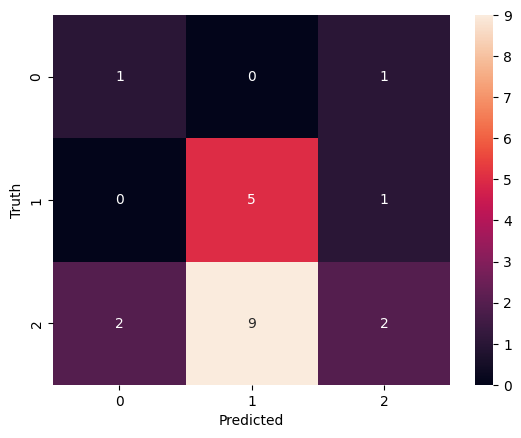

In [ ]:
evaluate_model(X_test, y_test, model)

In [ ]:
np.random.seed(28)

####################################################
# Please modify the following lines                #
# ! Don't change training/test/validation ratios ! #
####################################################

# Data preprocessing
features, labels = load_features_labels("./data/top", size=(512,512), color=True, flatten=False, identifiers=['MC', 'MS', 'C'])
features = np.array(features) # Datatype conversion of feature vector from list to array
labels = np.array(labels) # Datatype conversion of label vector from list to array
X_train, X_test, y_train, y_test = split_data(features, labels) # Split features and labels into training and testing datasets
y_train, y_test = encode_labels(y_train, y_test) # Encode labels

# Model definition
model = Sequential()
model.add(Conv2D(4, 5,  input_shape = X_train[0].shape, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(8, 3, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(8, 3, activation = 'relu', padding="same"))
model.add(GlobalMaxPooling2D())
model.add(Dense(8, activation = 'relu'))
model.add(Dense(y_train[0].shape[0], activation = 'softmax'))

# Model compilation
optimizer=Adam(learning_rate=0.0005)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

# Model training
model.fit(np.array(X_train), np.array(y_train), epochs = 50, batch_size = 2, validation_split=0.1,
          verbose = 1, sample_weight=compute_sample_weight('balanced', y_train))

# Model evaluation
evaluate_model(X_test, y_test, model)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 33.2971 - accuracy: 0.0909

22/22 [==============================] - 14s 579ms/step - loss: 33.2971 - accuracy: 0.0909 - val_loss: 14.0907 - val_accuracy: 0.0000e+00
Epoch 2/50
22/22 [==============================] - ETA: 0s - loss: 6.9987 - accuracy: 0.1591

22/22 [==============================] - 18s 828ms/step - loss: 6.9987 - accuracy: 0.1591 - val_loss: 6.6927 - val_accuracy: 0.6000
Epoch 3/50
22/22 [==============================] - ETA: 0s - loss: 4.6224 - accuracy: 0.1818

22/22 [==============================] - 12s 553ms/step - loss: 4.6224 - accuracy: 0.1818 - val_loss: 4.3228 - val_accuracy: 0.4000
Epoch 4/50
22/22 [==============================] - ETA: 0s - loss: 3.0619 - accuracy: 0.1591

22/22 [==============================] - 16s 747ms/step - loss: 3.0619 - accuracy: 0.1591 - val_loss: 2.3351 - val_accuracy: 0.2000
Epoch 5/50
22/22 [==============================] - ETA: 0s - loss: 1.8483 - accuracy: 0.2045

22/22 [==============================] - 16s 734ms/step - loss: 1.8483 - accuracy: 0.2045 - val_loss: 1.1627 - val_accuracy: 0.2000
Epoch 6/50
17/22 [======================>.......] - ETA: 3s - loss: 1.3163 - accuracy: 0.1765

KeyboardInterrupt: ignored

In [ ]:
# Data preprocessing
features, labels = load_features_labels("./data/top", size=(512,512), color=True, flatten=False, identifiers=['MC', 'MS', 'C'])
features = np.array(features) # Datatype conversion of feature vector from list to array
labels = np.array(labels) # Datatype conversion of label vector from list to array
X_train, X_test, y_train, y_test = split_data(features, labels) # Split features and labels into training and testing datasets
y_train, y_test = encode_labels(y_train, y_test) # Encode labels

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
### Create and show data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

In [ ]:
random_index = random.randint(0, len(features)) # Randomly select one image
datagen.fit(features[[random_index]]) # Fit the image generator with the randomly selected image

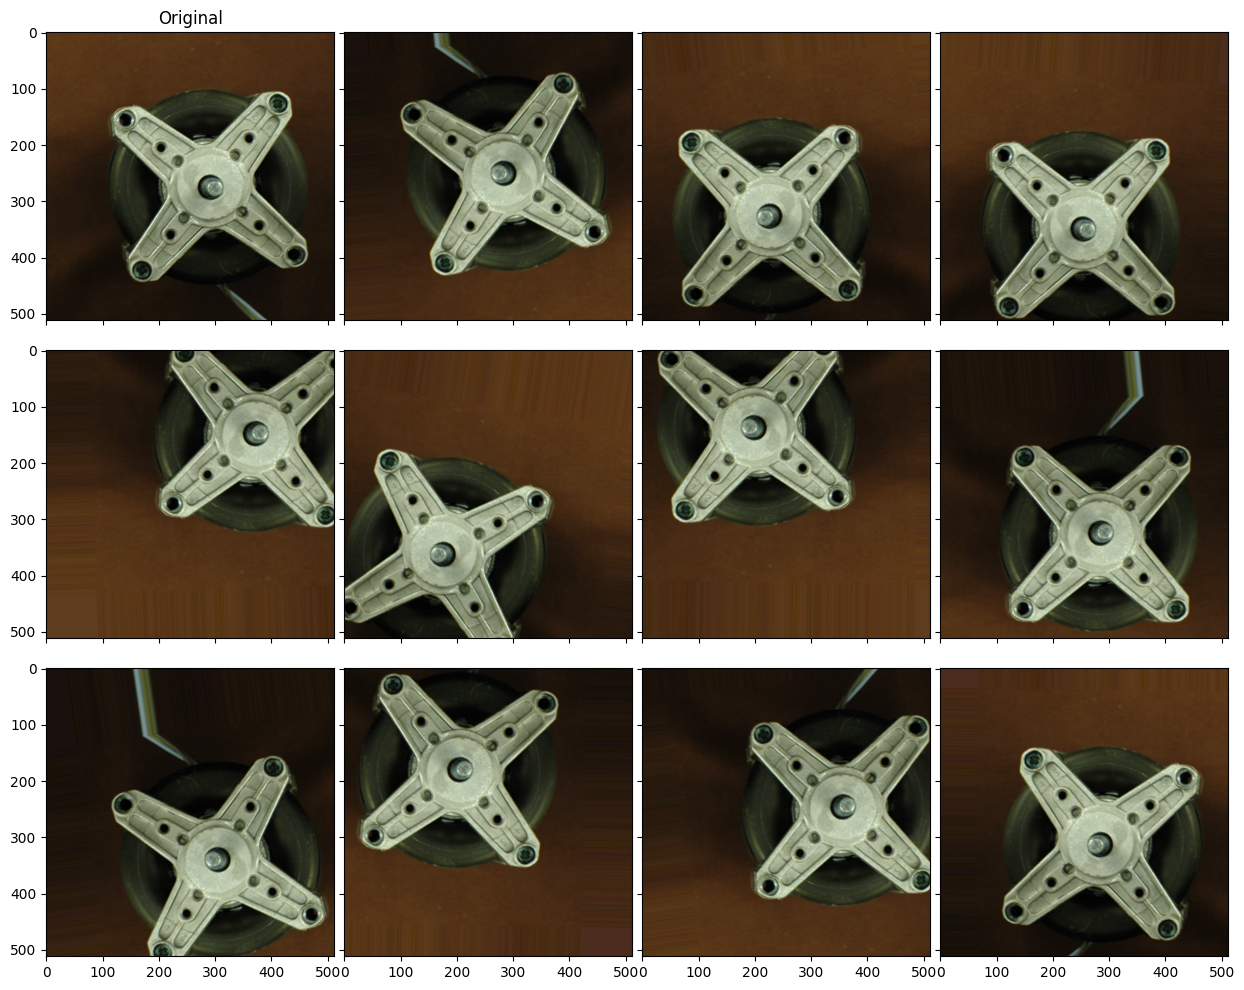

In [ ]:
# Display the random augmentations
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=(0.1, 0.3))

grid[0].imshow(features[random_index])
grid[0].set_title("Original")
for i, ax in enumerate(grid[1:]):
    image = datagen.flow(features[[random_index]]).next()[0].astype(int)
    ax.imshow(image) # Plot image
plt.show()

In [ ]:
### Run model training with given data generator
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size=0.9, stratify=y_train, random_state=21)

datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

datagen.fit(np.array(X_train))

model = Sequential()
model.add(Conv2D(8, 5,  input_shape = X_train[0].shape, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(8, 5, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(16, 5, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(16, 3, activation = 'relu', padding="same"))
model.add(GlobalMaxPooling2D())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(y_train[0].shape[0], activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

model.fit(datagen.flow(np.array(X_train), np.array(y_train), batch_size=8), validation_data=(X_validation, y_validation),
          steps_per_epoch=len(X_train) / 8, epochs=50)

Epoch 1/50
5/5 [==============================] - 28s 4s/step - loss: 23.6130 - accuracy: 0.3182 - val_loss: 1.9741 - val_accuracy: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 20s 4s/step - loss: 1.6434 - accuracy: 0.4773 - val_loss: 1.8714 - val_accuracy: 0.6000
Epoch 3/50
5/5 [==============================] - 25s 5s/step - loss: 1.1261 - accuracy: 0.5682 - val_loss: 0.8332 - val_accuracy: 0.2000
Epoch 4/50
5/5 [==============================] - 18s 3s/step - loss: 1.0848 - accuracy: 0.3182 - val_loss: 0.7715 - val_accuracy: 0.2000
Epoch 5/50
5/5 [==============================] - 20s 3s/step - loss: 0.9416 - accuracy: 0.4773 - val_loss: 0.6811 - val_accuracy: 0.6000
Epoch 6/50
5/5 [==============================] - 22s 5s/step - loss: 0.8900 - accuracy: 0.5909 - val_loss: 0.6719 - val_accuracy: 0.6000
Epoch 7/50
5/5 [==============================] - 18s 3s/step - loss: 0.8557 - accuracy: 0.6136 - val_loss: 0.6581 - val_accuracy: 1.0000
Epoch 8/50
5/5 [=============

1/1 [==============================] - 3s 3s/step
               precision    recall  f1-score   support

     Complete       0.50      0.50      0.50         2
Missing cover       0.80      0.67      0.73         6
Missing screw       0.86      0.92      0.89        13

     accuracy                           0.81        21
    macro avg       0.72      0.70      0.71        21
 weighted avg       0.81      0.81      0.81        21



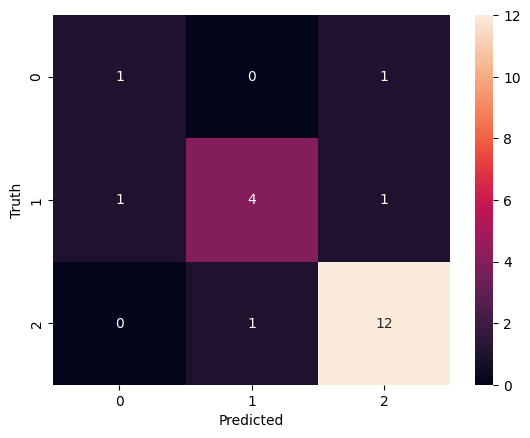

In [ ]:
evaluate_model(X_test, y_test, model)

In [ ]:
### Changed parameters
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size=0.9, stratify=y_train, random_state=21)

datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.5,
    height_shift_range=0.5,
    horizontal_flip=True,
    vertical_flip=True)

datagen.fit(np.array(X_train))

model = Sequential()
model.add(Conv2D(8, 5,  input_shape = X_train[0].shape, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(8, 5, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(16, 5, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(16, 3, activation = 'relu', padding="same"))
model.add(GlobalMaxPooling2D())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(y_train[0].shape[0], activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

model.fit(datagen.flow(np.array(X_train), np.array(y_train), batch_size=8), validation_data=(X_validation, y_validation),
          steps_per_epoch=len(X_train) / 8, epochs=50)

Epoch 1/50
4/4 [==============================] - 17s 3s/step - loss: 4.1459 - accuracy: 0.5641 - val_loss: 1.2874 - val_accuracy: 0.4000
Epoch 2/50
4/4 [==============================] - 16s 3s/step - loss: 1.1033 - accuracy: 0.5128 - val_loss: 1.6614 - val_accuracy: 0.2000
Epoch 3/50
4/4 [==============================] - 14s 3s/step - loss: 0.9689 - accuracy: 0.6410 - val_loss: 2.0480 - val_accuracy: 0.4000
Epoch 4/50
4/4 [==============================] - 15s 3s/step - loss: 0.8414 - accuracy: 0.6667 - val_loss: 1.7476 - val_accuracy: 0.4000
Epoch 5/50
4/4 [==============================] - 15s 3s/step - loss: 1.0137 - accuracy: 0.4359 - val_loss: 1.1276 - val_accuracy: 0.4000
Epoch 6/50
4/4 [==============================] - 15s 3s/step - loss: 0.9044 - accuracy: 0.5385 - val_loss: 0.8611 - val_accuracy: 0.4000
Epoch 7/50
4/4 [==============================] - 16s 3s/step - loss: 0.9203 - accuracy: 0.5641 - val_loss: 0.7492 - val_accuracy: 0.6000
Epoch 8/50
4/4 [==================

1/1 [==============================] - 3s 3s/step
               precision    recall  f1-score   support

     Complete       0.00      0.00      0.00         2
Missing cover       0.33      0.17      0.22         6
Missing screw       0.71      0.92      0.80        13

     accuracy                           0.62        21
    macro avg       0.35      0.36      0.34        21
 weighted avg       0.53      0.62      0.56        21



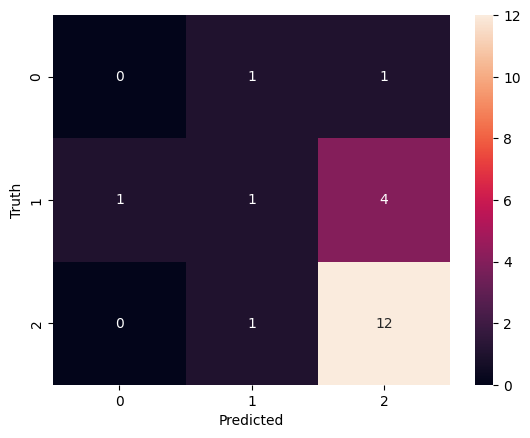

In [ ]:
evaluate_model(X_test, y_test, model)

Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 14.1109 - accuracy: 0.1143

18/18 [==============================] - 10s 518ms/step - loss: 14.1109 - accuracy: 0.1143 - val_loss: 7.8277 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 4.5859 - accuracy: 0.1714

18/18 [==============================] - 9s 483ms/step - loss: 4.5859 - accuracy: 0.1714 - val_loss: 5.6861 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 3.0754 - accuracy: 0.1429

18/18 [==============================] - 10s 576ms/step - loss: 3.0754 - accuracy: 0.1429 - val_loss: 3.7462 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 2.2470 - accuracy: 0.1143

18/18 [==============================] - 8s 429ms/step - loss: 2.2470 - accuracy: 0.1143 - val_loss: 2.9834 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - ETA: 0s - loss: 1.6843 - accuracy: 0.1429

18/18 [==============================] - 10s 578ms/step - loss: 1.6843 - accuracy: 0.1429 - val_loss: 2.1308 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - ETA: 0s - loss: 1.2657 - accuracy: 0.1429

18/18 [==============================] - 9s 481ms/step - loss: 1.2657 - accuracy: 0.1429 - val_loss: 1.5442 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - ETA: 0s - loss: 1.0579 - accuracy: 0.1429

18/18 [==============================] - 9s 505ms/step - loss: 1.0579 - accuracy: 0.1429 - val_loss: 1.2972 - val_accuracy: 0.0000e+00
Epoch 8/50
18/18 [==============================] - ETA: 0s - loss: 0.9104 - accuracy: 0.2000

18/18 [==============================] - 10s 574ms/step - loss: 0.9104 - accuracy: 0.2000 - val_loss: 1.1038 - val_accuracy: 0.0000e+00
Epoch 9/50
18/18 [==============================] - ETA: 0s - loss: 0.8583 - accuracy: 0.2000

18/18 [==============================] - 8s 429ms/step - loss: 0.8583 - accuracy: 0.2000 - val_loss: 1.0242 - val_accuracy: 0.2500
Epoch 10/50
18/18 [==============================] - ETA: 0s - loss: 0.8419 - accuracy: 0.3429

18/18 [==============================] - 10s 574ms/step - loss: 0.8419 - accuracy: 0.3429 - val_loss: 0.9707 - val_accuracy: 0.2500
Epoch 11/50
18/18 [==============================] - ETA: 0s - loss: 0.8057 - accuracy: 0.5143

18/18 [==============================] - 8s 450ms/step - loss: 0.8057 - accuracy: 0.5143 - val_loss: 1.0636 - val_accuracy: 0.2500
Epoch 12/50
18/18 [==============================] - ETA: 0s - loss: 0.7363 - accuracy: 0.3714

18/18 [==============================] - 10s 539ms/step - loss: 0.7363 - accuracy: 0.3714 - val_loss: 1.0058 - val_accuracy: 0.2500
Epoch 13/50
18/18 [==============================] - ETA: 0s - loss: 0.7659 - accuracy: 0.5714

18/18 [==============================] - 10s 550ms/step - loss: 0.7659 - accuracy: 0.5714 - val_loss: 1.2045 - val_accuracy: 0.2500
Epoch 14/50
18/18 [==============================] - ETA: 0s - loss: 0.7447 - accuracy: 0.4286

18/18 [==============================] - 8s 437ms/step - loss: 0.7447 - accuracy: 0.4286 - val_loss: 0.9554 - val_accuracy: 0.2500
Epoch 15/50
18/18 [==============================] - ETA: 0s - loss: 0.6612 - accuracy: 0.5143

18/18 [==============================] - 10s 576ms/step - loss: 0.6612 - accuracy: 0.5143 - val_loss: 1.0325 - val_accuracy: 0.2500
Epoch 16/50
18/18 [==============================] - ETA: 0s - loss: 0.6376 - accuracy: 0.6000

18/18 [==============================] - 8s 430ms/step - loss: 0.6376 - accuracy: 0.6000 - val_loss: 0.9979 - val_accuracy: 0.2500
Epoch 17/50
18/18 [==============================] - ETA: 0s - loss: 0.5928 - accuracy: 0.5714

18/18 [==============================] - 10s 571ms/step - loss: 0.5928 - accuracy: 0.5714 - val_loss: 1.0583 - val_accuracy: 0.2500
Epoch 18/50
18/18 [==============================] - ETA: 0s - loss: 0.5513 - accuracy: 0.7429

18/18 [==============================] - 9s 513ms/step - loss: 0.5513 - accuracy: 0.7429 - val_loss: 1.0669 - val_accuracy: 0.2500
Epoch 19/50
18/18 [==============================] - ETA: 0s - loss: 0.5680 - accuracy: 0.6571

18/18 [==============================] - 9s 476ms/step - loss: 0.5680 - accuracy: 0.6571 - val_loss: 0.9863 - val_accuracy: 0.2500
Epoch 20/50
18/18 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.7429

18/18 [==============================] - 10s 573ms/step - loss: 0.6925 - accuracy: 0.7429 - val_loss: 0.9504 - val_accuracy: 0.2500
Epoch 21/50
18/18 [==============================] - ETA: 0s - loss: 0.7002 - accuracy: 0.6286

18/18 [==============================] - 8s 433ms/step - loss: 0.7002 - accuracy: 0.6286 - val_loss: 1.1440 - val_accuracy: 0.0000e+00
Epoch 22/50
18/18 [==============================] - ETA: 0s - loss: 0.6164 - accuracy: 0.4571

18/18 [==============================] - 10s 577ms/step - loss: 0.6164 - accuracy: 0.4571 - val_loss: 1.0099 - val_accuracy: 0.0000e+00
Epoch 23/50
18/18 [==============================] - ETA: 0s - loss: 0.5464 - accuracy: 0.6571

18/18 [==============================] - 8s 471ms/step - loss: 0.5464 - accuracy: 0.6571 - val_loss: 0.8620 - val_accuracy: 0.2500
Epoch 24/50
18/18 [==============================] - ETA: 0s - loss: 0.4881 - accuracy: 0.7714

18/18 [==============================] - 10s 521ms/step - loss: 0.4881 - accuracy: 0.7714 - val_loss: 0.9048 - val_accuracy: 0.2500
Epoch 25/50
18/18 [==============================] - ETA: 0s - loss: 0.4507 - accuracy: 0.8286

18/18 [==============================] - 10s 580ms/step - loss: 0.4507 - accuracy: 0.8286 - val_loss: 0.8490 - val_accuracy: 0.2500
Epoch 26/50
18/18 [==============================] - ETA: 0s - loss: 0.4998 - accuracy: 0.8571

18/18 [==============================] - 8s 430ms/step - loss: 0.4998 - accuracy: 0.8571 - val_loss: 1.1373 - val_accuracy: 0.5000
Epoch 27/50
18/18 [==============================] - ETA: 0s - loss: 0.4775 - accuracy: 0.7714

18/18 [==============================] - 10s 573ms/step - loss: 0.4775 - accuracy: 0.7714 - val_loss: 0.8624 - val_accuracy: 0.2500
Epoch 28/50
18/18 [==============================] - ETA: 0s - loss: 0.3970 - accuracy: 0.8857

18/18 [==============================] - 8s 432ms/step - loss: 0.3970 - accuracy: 0.8857 - val_loss: 1.0196 - val_accuracy: 0.2500
Epoch 29/50
18/18 [==============================] - ETA: 0s - loss: 0.3811 - accuracy: 0.8286

18/18 [==============================] - 10s 556ms/step - loss: 0.3811 - accuracy: 0.8286 - val_loss: 0.8559 - val_accuracy: 0.2500
Epoch 30/50
18/18 [==============================] - ETA: 0s - loss: 0.3567 - accuracy: 0.8857

18/18 [==============================] - 9s 526ms/step - loss: 0.3567 - accuracy: 0.8857 - val_loss: 0.8725 - val_accuracy: 0.2500
Epoch 31/50
18/18 [==============================] - ETA: 0s - loss: 0.3425 - accuracy: 0.9143

18/18 [==============================] - 9s 458ms/step - loss: 0.3425 - accuracy: 0.9143 - val_loss: 0.9326 - val_accuracy: 0.2500
Epoch 32/50
18/18 [==============================] - ETA: 0s - loss: 0.3089 - accuracy: 0.9429

18/18 [==============================] - 10s 574ms/step - loss: 0.3089 - accuracy: 0.9429 - val_loss: 0.8237 - val_accuracy: 0.2500
Epoch 33/50
18/18 [==============================] - ETA: 0s - loss: 0.3064 - accuracy: 0.9714

18/18 [==============================] - 8s 430ms/step - loss: 0.3064 - accuracy: 0.9714 - val_loss: 0.9081 - val_accuracy: 0.2500
Epoch 34/50
18/18 [==============================] - ETA: 0s - loss: 0.3077 - accuracy: 0.9714

18/18 [==============================] - 10s 575ms/step - loss: 0.3077 - accuracy: 0.9714 - val_loss: 0.7863 - val_accuracy: 0.2500
Epoch 35/50
18/18 [==============================] - ETA: 0s - loss: 0.2896 - accuracy: 0.9714

18/18 [==============================] - 9s 492ms/step - loss: 0.2896 - accuracy: 0.9714 - val_loss: 0.7664 - val_accuracy: 0.2500
Epoch 36/50
18/18 [==============================] - ETA: 0s - loss: 0.2793 - accuracy: 0.9143

18/18 [==============================] - 9s 493ms/step - loss: 0.2793 - accuracy: 0.9143 - val_loss: 0.7720 - val_accuracy: 0.2500
Epoch 37/50
18/18 [==============================] - ETA: 0s - loss: 0.2687 - accuracy: 1.0000

18/18 [==============================] - 10s 573ms/step - loss: 0.2687 - accuracy: 1.0000 - val_loss: 0.7883 - val_accuracy: 0.2500
Epoch 38/50
18/18 [==============================] - ETA: 0s - loss: 0.2968 - accuracy: 0.7429

18/18 [==============================] - 8s 433ms/step - loss: 0.2968 - accuracy: 0.7429 - val_loss: 0.9176 - val_accuracy: 0.2500
Epoch 39/50
18/18 [==============================] - ETA: 0s - loss: 0.3392 - accuracy: 0.8571

18/18 [==============================] - 10s 573ms/step - loss: 0.3392 - accuracy: 0.8571 - val_loss: 0.9926 - val_accuracy: 0.5000
Epoch 40/50
18/18 [==============================] - ETA: 0s - loss: 0.2359 - accuracy: 0.9143

18/18 [==============================] - 8s 462ms/step - loss: 0.2359 - accuracy: 0.9143 - val_loss: 0.7152 - val_accuracy: 0.2500
Epoch 41/50
18/18 [==============================] - ETA: 0s - loss: 0.2141 - accuracy: 0.9714

18/18 [==============================] - 10s 530ms/step - loss: 0.2141 - accuracy: 0.9714 - val_loss: 0.7190 - val_accuracy: 0.2500
Epoch 42/50
18/18 [==============================] - ETA: 0s - loss: 0.2018 - accuracy: 1.0000

18/18 [==============================] - 10s 566ms/step - loss: 0.2018 - accuracy: 1.0000 - val_loss: 0.8304 - val_accuracy: 0.5000
Epoch 43/50
18/18 [==============================] - ETA: 0s - loss: 0.1936 - accuracy: 1.0000

18/18 [==============================] - 8s 433ms/step - loss: 0.1936 - accuracy: 1.0000 - val_loss: 0.6628 - val_accuracy: 0.2500
Epoch 44/50
18/18 [==============================] - ETA: 0s - loss: 0.1779 - accuracy: 1.0000

18/18 [==============================] - 10s 575ms/step - loss: 0.1779 - accuracy: 1.0000 - val_loss: 0.8022 - val_accuracy: 0.5000
Epoch 45/50
18/18 [==============================] - ETA: 0s - loss: 0.1710 - accuracy: 1.0000

18/18 [==============================] - 8s 429ms/step - loss: 0.1710 - accuracy: 1.0000 - val_loss: 0.6358 - val_accuracy: 0.2500
Epoch 46/50
18/18 [==============================] - ETA: 0s - loss: 0.1674 - accuracy: 1.0000

18/18 [==============================] - 10s 562ms/step - loss: 0.1674 - accuracy: 1.0000 - val_loss: 0.7249 - val_accuracy: 0.5000
Epoch 47/50
18/18 [==============================] - ETA: 0s - loss: 0.1534 - accuracy: 1.0000

18/18 [==============================] - 9s 529ms/step - loss: 0.1534 - accuracy: 1.0000 - val_loss: 0.6945 - val_accuracy: 0.2500
Epoch 48/50
18/18 [==============================] - ETA: 0s - loss: 0.1290 - accuracy: 1.0000

18/18 [==============================] - 9s 463ms/step - loss: 0.1290 - accuracy: 1.0000 - val_loss: 0.6674 - val_accuracy: 0.5000
Epoch 49/50
18/18 [==============================] - ETA: 0s - loss: 0.1218 - accuracy: 1.0000

18/18 [==============================] - 10s 576ms/step - loss: 0.1218 - accuracy: 1.0000 - val_loss: 0.6438 - val_accuracy: 0.2500
Epoch 50/50
18/18 [==============================] - ETA: 0s - loss: 0.1178 - accuracy: 1.0000

1/1 [==============================] - 2s 2s/step
               precision    recall  f1-score   support

     Complete       0.00      0.00      0.00         2
Missing cover       0.25      0.17      0.20         6
Missing screw       0.71      0.77      0.74        13

     accuracy                           0.52        21
    macro avg       0.32      0.31      0.31        21
 weighted avg       0.51      0.52      0.52        21



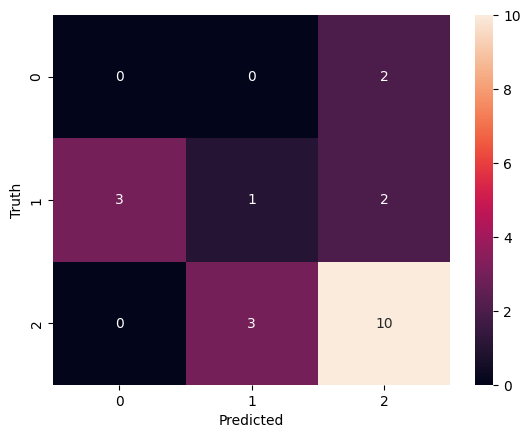

In [ ]:
# Data preprocessing
features, labels = load_features_labels("./data/top", size=(512,512), color=True, flatten=False, identifiers=['MC', 'MS', 'C', 'NS'])
features = np.array(features)
labels = np.array(labels)

# Model definition
model = Sequential()
model.add(Conv2D(4, 5,  input_shape = X_train[0].shape, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(8, 3, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(8, 3, activation = 'relu', padding="same"))
model.add(GlobalMaxPooling2D())
model.add(Dense(8, activation = 'relu'))
model.add(Dense(y_train[0].shape[0], activation = 'softmax'))

# Model compilation
optimizer=Adam(learning_rate=0.0005)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

# Model training
model.fit(np.array(X_train), np.array(y_train), epochs = 50, batch_size = 2, validation_split=0.1,
          verbose = 1, sample_weight=compute_sample_weight('balanced', y_train))

# Model evaluation
evaluate_model(X_test, y_test, model)